# <img src="../assets/logo_infnetv1.png" alt="Infnet logo" height="60"/> Projeto de Disciplina de IA generativa para linguagem (Large Language Model) [25E2_3]
<img src="https://img.shields.io/badge/python-v._3.10.18-blue?style=flat-square&logo=python&logoColor=white" alt="python_logo" height="20"/>
<img src="https://img.shields.io/badge/jupyter-v._5.7.2-blue?style=flat-square&logo=jupyter&logoColor=white" alt="jupyter_logo" height="20"/>
<img src="https://img.shields.io/badge/anaconda-v._23.7.4-blue?style=flat-square&logo=anaconda&logoColor=white" alt="anaconda_logo" height="20"/>

<img src="https://img.shields.io/badge/Github-151b23?style=flat-square&logo=github" alt="anaconda_logo" height="20"/> https://github.com/GitMateusTeixeira/03-ml-modeling/tree/main/06_infnet_llm_pd/03_analise_de_dados_com_ner

#### Aluno: Mateus Teixeira Ramos da Silva

Este notebook cumpre os requisitos da 'Parte 3' do PD. A saber:

Parte 3. Análise de Dados com NER

- 3.. Baixe o conjunto de dados de notícias disponível em: Folha UOL News Dataset.

- 3.1. Utilize o modelo 'monilouise/ner_pt_br' para identificar e extrair entidades mencionadas nas notícias.

- 3.2. Crie um ranking das organizações que mais apareceram na seção "Mercado" no primeiro trimestre de 2015.

- 3.3. Apresente os resultados em um relatório detalhado, incluindo a metodologia utilizada e visualizações para apoiar a análise.


### Índice

---

- <a href='#parte-1-download-dos-dados'>Parte 1. Download dos dados</a>

- <a href='#parte-2-exploração-e-manipulação-dos-dados'>Parte 2. Exploração e manipulação dos dados</a>

- <a href='#parte-3-tokenização'>Parte 3. Tokenização</a>

- <a href='#parte-4-ner'>Parte 4. NER</a>

    - <a href='#parte-41-extrair-as-organizações-de-cada-texto'>Parte 4.1. Extrair as organizações de cada texto</a>

    - <a href='#parte-42-tratamento-e-limpeza-das-organizações'>Parte 4.2. Tratamento e limpeza das organizações</a>

- <a href='#parte-5-contar-as-organizações'>Parte 5. Contar as organizações</a>

    - <a href='#parte-51-remover-termos-sem-valor'>Parte 5.1. Remover termos sem valor</a>

- <a href='#parte-6-visualizar-os-dados'>Parte 6. Visualizar os dados</a>

    - <a href='#parte-61-gráfico-de-contagem'>Parte 6.1. Gráfico de contagem</a>

    - <a href='#parte-62-lematizar-o-texto-para-nuvem-de-palavras'>Parte 6.2. Lematizar o texto para Nuvem de Palavars</a>

    - <a href='#parte-63-nuvem-de-palavras'>Parte 6.3. Nuvem de Palavras</a>

    - <a href='#parte-64-nuvem-de-organizações'>Parte 6.4. Nuvem de Organizações</a>

- <a href='#feito-por'>Feito por</a>

## Importar os pacotes

---


In [1]:
import kaggle
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import spacy
import warnings

from collections import Counter
from datetime import datetime
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
from wordcloud import WordCloud

tqdm.pandas()  # Habilita a barra de progresso no pandas
warnings.filterwarnings('ignore')

c:\ProgramData\anaconda3\envs\env_25E2_3_v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parte 1. Download dos dados

---

<a href='#índice'>Voltar ao início</a>

In [2]:
# baixar os dados com a api do Kaggle
kaggle.api.dataset_download_files('marlesson/news-of-the-site-folhauol', 
                                  path='../data/01-raw/', 
                                  unzip=True)

Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol


In [3]:
# ler os dados
path = '../data/01-raw/'
file = 'articles.csv'
pathfile = os.path.join(path, file)

df = pd.read_csv(pathfile)

## Parte 2. Exploração e manipulação dos dados

---

<a href='#índice'>Voltar ao início</a>

In [4]:
# explorar o tamanho dos dados antes de qualquer tratamento
df.shape

(167053, 6)

In [5]:
df.head(3)

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...


In [6]:
df.columns

Index(['title', 'text', 'date', 'category', 'subcategory', 'link'], dtype='object')

In [7]:
# converter a coluna 'date' para datettime para filtrar posteriormente
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [8]:
# filtar a coluna 'category' por 'Mercado'
df = df[df['category'].str.lower() == 'mercado']

In [9]:
# verificar o tamanho após o primeiro filtro
df.shape

(20970, 6)

In [10]:
# exibir uma sample para verificar o resultado
df.sample(3)

,title,text,date,category,subcategory,link
96534,Argentina libera despesas em dólar e prevê ent...,O novo governo da Argentina colocou fim nesta ...,2015-12-16,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
14937,Crise política afeta rentabilidade dos fundos ...,A crise política afetou a rentabilidade de tod...,2017-08-06,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/06/1...
99064,Reportagem da Folha sobre investidor mais jove...,"A reportagem da Folha ""Príncipe da Bolsa"", de ...",2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...


In [11]:
# aplicar o segundo filtro. filtrar as notícias do 1º trimestre de 2015
start = datetime(2015, 1, 1)
end = datetime(2015, 3, 31)
df = df[(df['date'] >= start) & (df['date'] <= end)]

In [12]:
# verificar o tamanho após o segundo filtro
df.shape

(2111, 6)

In [13]:
# exibir uma sample para verificar o resultado
df.sample(3)

,title,text,date,category,subcategory,link
162691,Número de imóveis financiados com recursos da ...,Os financiamentos imobiliários com recursos da...,2015-01-21,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/01/1...
160052,Remanejamento de população atrasa entrega da m...,"Terceira maior obra do PAC, com investimento p...",2015-01-02,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/02/1...
122689,Entenda a situação dos clientes do HSBC e do B...,"Após a última aquisição do Bradesco, muitas dú...",2015-03-08,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/08/1...


## Parte 3. Tokenização

---

<a href='#índice'>Voltar ao início</a>

In [14]:
# carregar modelo e tokenizer
model_name = "monilouise/ner_pt_br"
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModelForTokenClassification.from_pretrained(model_name)

Some weights of the model checkpoint at monilouise/ner_pt_br were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# criar pipeline de NER
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

Device set to use cpu


In [16]:
df.columns

Index(['title', 'text', 'date', 'category', 'subcategory', 'link'], dtype='object')

## Parte 4. NER

---

<a href='#índice'>Voltar ao início</a>

In [17]:
# aplicar NER nos textos
def extrair_entidades(texto):
    try:
        return ner_pipeline(texto)
    except:
        return []

In [18]:
# aplicar na coluna de texto
df['entidades'] = df['text'].progress_apply(extrair_entidades)

100%|██████████| 2111/2111 [10:38<00:00,  3.30it/s]


In [21]:
# exibir uma sample da nova coluna
df['entidades'].sample(n=3, random_state=17)

149362    [{'entity_group': 'PESSOA', 'score': 0.9898215...
147695    [{'entity_group': 'PESSOA', 'score': 0.9935941...
99514                                                    []
Name: entidades, dtype: object

### Parte 4.1. Extrair as organizações de cada texto

---

<a href='#índice'>Voltar ao início</a>

In [22]:
# extrair apenas as organizações de cada texto
def extrair_organizacoes(entidades):
    return [ent['word'] for ent in entidades if 'ORG' in ent['entity_group'].upper()]

In [23]:
# aplicar a função
df['organizacoes'] = df['entidades'].progress_apply(extrair_organizacoes)

100%|██████████| 2111/2111 [00:00<00:00, 46470.32it/s]


In [24]:
# exibir uma sample da nova coluna
df['organizacoes'].sample(n=3, random_state=17)

149362    [Fi, ##tch, Fi, Standard and, Poor´s]
147695                                  [Folha]
99514                                        []
Name: organizacoes, dtype: object

### Parte 4.2. Tratamento e limpeza das organizações

---

<a href='#índice'>Voltar ao início</a>

In [25]:
# executar a limpeza das organizações
def reconstruir_e_limpar(orgs):
    """

    Limpa as organizações.

    Parâmetros:
    - orgs: recebe a coluna de organizações.

    Retorna:
    - termos_limpos: list[] com as organizações limpas.
        
    """

    termos = []
    atual = ''

    for token in orgs:
        """
        se o token começar com '##', o token atual vai ser concatenado com o token anterior
        """
        if token.startswith('##'):
            atual += token[2:]

        else:
            if atual:
                termos.append(atual)
            atual = token

    if atual:
        termos.append(atual)

    # Limpar cada termo (remover símbolos e padronizar com "_")
    termos_limpos = []

    for t in termos:
        t = re.sub(r'\W+', ' ', t)     # Remove caracteres não alfanuméricos
        t = t.strip()
        t = t.replace(' ', '_')        # Substitui espaços por "_"
        if t:
            termos_limpos.append(t)

    return termos_limpos

In [26]:
# aplicar a função
df['organizacoes_limpa'] = df['organizacoes'].progress_apply(reconstruir_e_limpar)

100%|██████████| 2111/2111 [00:00<00:00, 69794.31it/s]


In [27]:
# exibir as organizações antes do tratamento
df['organizacoes'].head(3)

99055    [Claro, grupo, América, Móvil, T, ##IM, O, ##i...
99063                                                   []
99064    [Folha, BM &, ##pa, Jornal do, Comércio ", Agê...
Name: organizacoes, dtype: object

In [28]:
# exibir as organizações depois do tratamento
df['organizacoes_limpa'].head(3)

99055    [Claro, grupo, América, Móvil, TIM, Oi, Vivo, ...
99063                                                   []
99064    [Folha, BM_pa, Jornal_do, Comércio, Agência, E...
Name: organizacoes_limpa, dtype: object

## Parte 5. Contar as organizações

---

<a href='#índice'>Voltar ao início</a>

In [29]:
# popular uma lista de listas com as organizações
todas_orgs = [org for sublist in df['organizacoes_limpa'] for org in sublist]

# contar as aparições
contagem = Counter(todas_orgs)

# converter para um DataFrame
df_orgs = pd.DataFrame(contagem.items(), columns=['organização', 'contagem'])
df_orgs = df_orgs.sort_values(by='contagem', ascending=False).reset_index(drop=True)

### Parte 5.1. Remover termos sem valor

---

<a href='#índice'>Voltar ao início</a>

In [30]:
# lista de termos a serem removidos por não terem muito valor para a análise
palavras_excluir = [
                    'Folha', 'Brasil', 'O', 's', 'S', 'P'
                    ]

# filtrar o DataFrame excluindo essas palavras
df_orgs_filtrado = df_orgs[~df_orgs['organização'].isin(palavras_excluir)].reset_index(drop=True)

## Parte 6. Visualizar os dados

---

<a href='#índice'>Voltar ao início</a>

### Parte 6.1. Gráfico de contagem

---

<a href='#índice'>Voltar ao início</a>

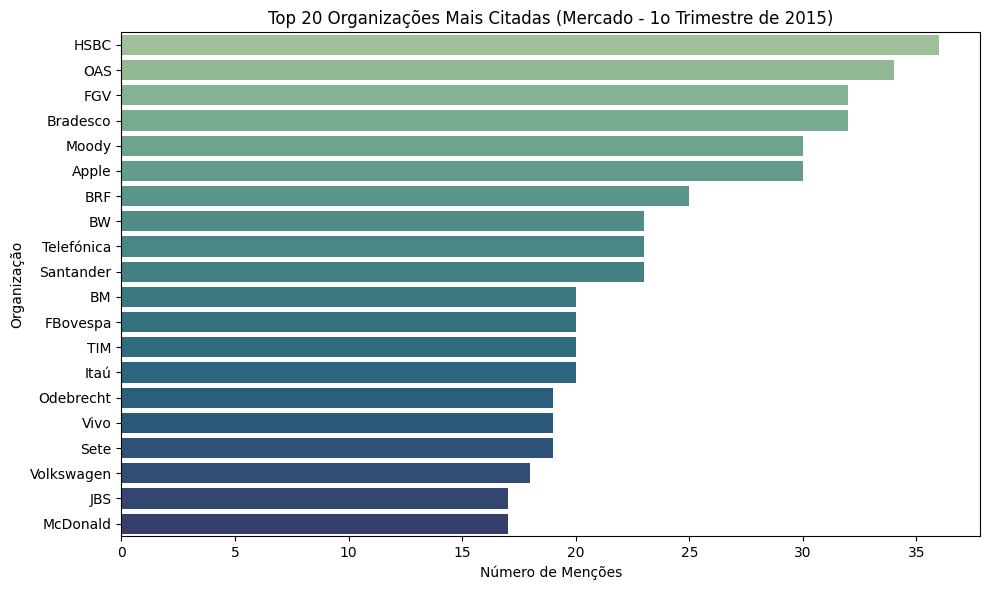

In [31]:
# exibir um gráfico com as principais organizações
top_10 = df_orgs_filtrado.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_10, y='organização', x='contagem', palette='crest')
plt.title('Top 20 Organizações Mais Citadas (Mercado - 1o Trimestre de 2015)')
plt.xlabel('Número de Menções')
plt.ylabel('Organização')
plt.tight_layout()
plt.show()

### Parte 6.2. Lematizar o texto para Nuvem de palavras

---

<a href='#índice'>Voltar ao início</a>

In [32]:
# baixar o modelo do spaCy
os.system("python -m spacy download pt_core_news_lg")

0

In [33]:
# carregar modelo português do spaCy
nlp = spacy.load("pt_core_news_lg")

In [34]:
# preencher textos nulos com string vazia, para evitar erros
df['spacy_doc'] = df['text'].fillna('').progress_apply(nlp)

100%|██████████| 2111/2111 [03:12<00:00, 10.99it/s]


In [40]:
# termos a excluir
termos_excluir = set([
    'a', 'afirmar', 'ainda',
    'de o', 'dizer',
    'e', 'ele', 'em o', 'esse', 'estar', 'fazer', 'folha',
    'i', 'ir', 'isso', 'já',
    'ma', 'mai', 'não',
    'o', 'ou',
    'para', 'por', 'por o',
    'quando', 'que',   
    'se', 'ser', 'seu', 
    'também', 'ter', 'todo',
    'um'
])

In [42]:
# lematizar o texto
def lematizar_texto(texto):
    doc = nlp(texto)
    lemas = [
        token.lemma_.lower()
        for token in doc
        if not token.is_punct
        and not token.is_space
        and token.pos_ != 'ADP' # remover preposições
        and token.lemma_.lower() not in termos_excluir
    ]
    return ' '.join(lemas)

In [43]:
# aplicar a lematização
df['texto_lematizado'] = df['text'].fillna('').progress_apply(lematizar_texto)

100%|██████████| 2111/2111 [03:01<00:00, 11.61it/s]


In [44]:
# exibir a nova coluna
df['texto_lematizado'].head(3)

99055    mercado telefonia celular perder 2,09 milhão l...
99063    presidente dilma rousseff sancionar alteração ...
99064    reportagem príncipe bolsa autoria danielle bra...
Name: texto_lematizado, dtype: object

### Parte 6.3. Nuvem de palavras

---

<a href='#índice'>Voltar ao início</a>

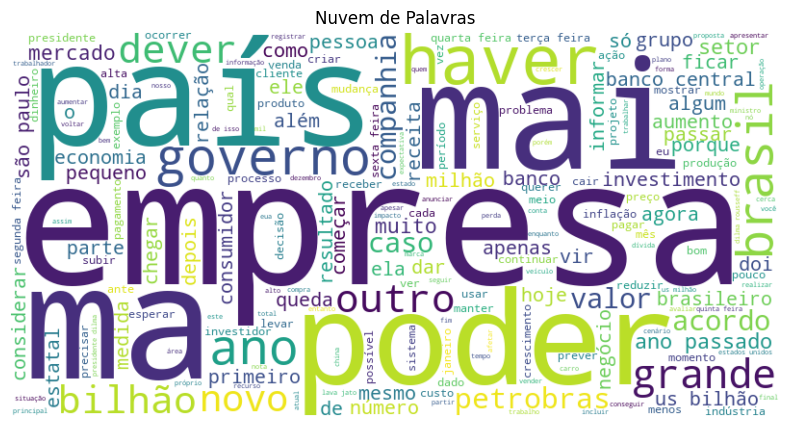

In [45]:
# Concatenar todos os textos lematizados
texto_total = ' '.join(df['texto_lematizado'])

# Verificar se há conteúdo para gerar a nuvem
if texto_total.strip():
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate(texto_total)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Palavras')
    plt.show()

else:
    print("Nenhum texto lematizado disponível para gerar a nuvem.")

### Parte 6.4. Nuvem de Organizações

---

<a href='#índice'>Voltar ao início</a>

In [46]:
# criar uma lista de palavras limpa
orgs = [
    org for sublist in df['organizacoes_limpa']
    for org in sublist
    if org not in palavras_excluir
]

# concatenar tudo em um texto só
texto_orgs = ' '.join(orgs)

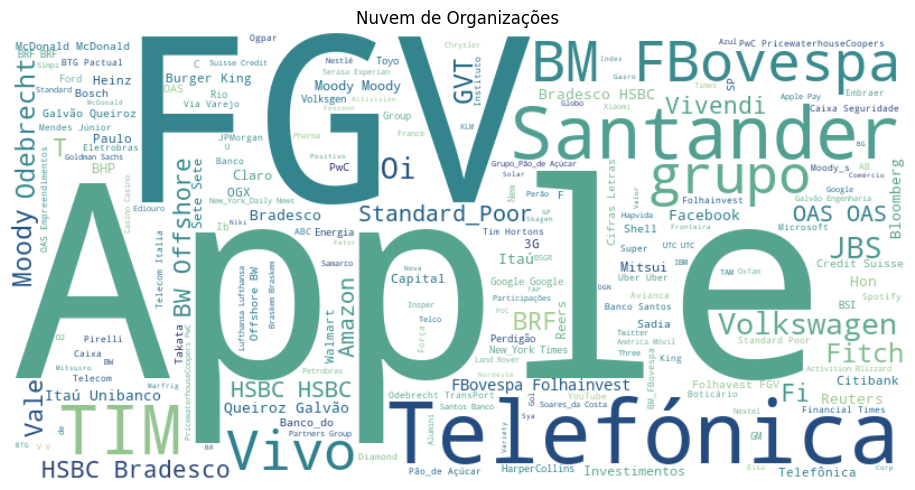

In [47]:
# gerar a nuvem de palavras das organizações
if texto_orgs.strip():
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='crest'
    ).generate(texto_orgs)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Organizações')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Nenhuma organização válida para gerar a nuvem.")

# Feito por
<div>
    <img src="../assets/logo_mt_ds.png" alt="mt_logo" style='width: 80px; vertical-align: middle;' align='left'>
    <span style="">Mateus Teixeira</span>
</div>
Cientista de dados
<br>
Pós-graduando em Inteligência Artifcial pela INFNET